In [ ]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#keras
import keras
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from keras.utils.vis_utils import plot_model

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%env name=test_samples1_512_4VR
!echo $name

env: name=test_samples1_512_4VR
test_samples1_512_4VR


In [ ]:
# copy samples file to directory
!cp ./drive/Shareddrives/Memoria/samples/$name.zip ./$name.zip

!unzip -o -q $name.zip -d ./samples

In [ ]:
set_seed(42)
np.random.seed(42)

In [ ]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# all file names and classes
files = {'1':[], '2':[], '3':[], '4':[]}

# Classes
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [
          1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19,
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38,
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74,
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140,
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184,
          200, 204, 232
        ]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

## Dataset Generation

In [ ]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/'
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1 + class2 + class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [ ]:
len(c1_img_list), len(c4_img_list)

(21504, 21482)

In [ ]:
files_target = [np.full(len(c1_img_list), '1', dtype=str),
                np.full(len(c4_img_list), '4', dtype=str) ]
[x.shape[0] for x in files_target]

[21504, 21482]

In [ ]:
# Data selection

c1_x = c1_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c4_y = files_target[1].copy()

In [ ]:
c_x = np.array(c1_x + c4_x)
c_y = np.concatenate((c1_y, c4_y))

In [ ]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)
dataset

,img,class
13420,./samples/rule_94/94_000_0011_4582.png,1
13452,./samples/rule_94/94_000_0146_3512.png,1
1000,./samples/rule_40/40_000_0153_8185.png,1
20416,./samples/rule_105/105_000_0189_1075.png,1
27443,./samples/rule_54/54_000_0113_6956.png,4
...,...,...
6265,./samples/rule_24/24_000_0172_5153.png,1
11284,./samples/rule_58/58_000_0166_1761.png,1
38158,./samples/rule_110/110_000_0235_7635.png,4
860,./samples/rule_40/40_000_0065_6220.png,1


## Data Split

In [ ]:
# get data from df
X_test = dataset['img'].values
y_test = dataset['class'].values.reshape(-1,1)

# one hot encoding
enc = joblib.load('./drive/Shareddrives/Memoria/encodings/encoder' + 'resnet_V2_4vr' + '.joblib')

# transform data
y_test = enc.transform(y_test)

print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

     1    4
0  1.0  0.0
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  0.0  1.0


In [ ]:
X_test[0], y_test[0]

('./samples/rule_94/94_000_0011_4582.png', array([1., 0.]))

## Images

In [ ]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='rgb')
        x = img_to_array(img1) / 255

        img_list.append(x)

    return np.array(img_list)

In [ ]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4

    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)

        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [ ]:
X_test = getImages(X_test)

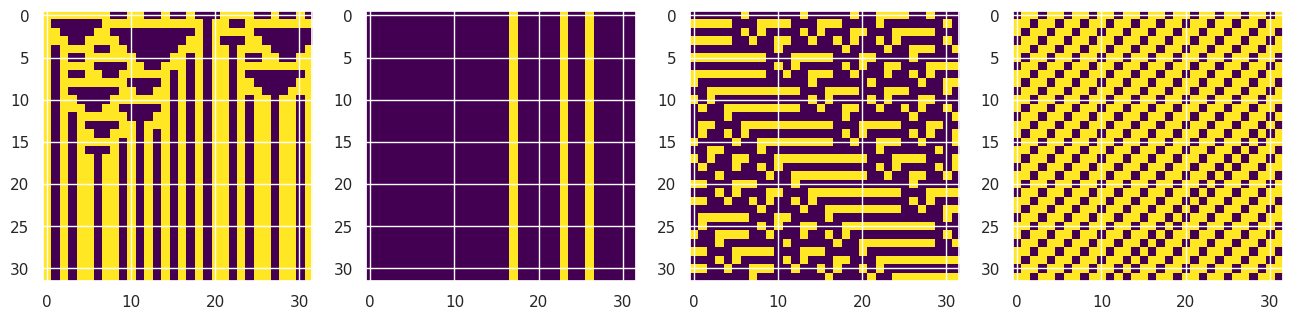

<Figure size 640x480 with 0 Axes>

In [ ]:
imagePreview(X_test)

In [ ]:
X_test[0].shape

(32, 32, 3)

## Testing

In [ ]:
# Model
model = keras.models.load_model('./drive/Shareddrives/Memoria/code/best_models/resnet_V2_4vr_best.h5')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=12)
print("test loss, test acc:", results)

Evaluate on test data
3583/3583 [==============================] - 26s 5ms/step - loss: 0.0377 - categorical_accuracy: 0.9954
test loss, test acc: [0.03767665848135948, 0.9954403638839722]


In [ ]:
y_pred = model.predict(X_test)

1344/1344 [==============================] - 5s 3ms/step


In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     21504
           1       0.99      1.00      1.00     21482

    accuracy                           1.00     42986
   macro avg       1.00      1.00      1.00     42986
weighted avg       1.00      1.00      1.00     42986



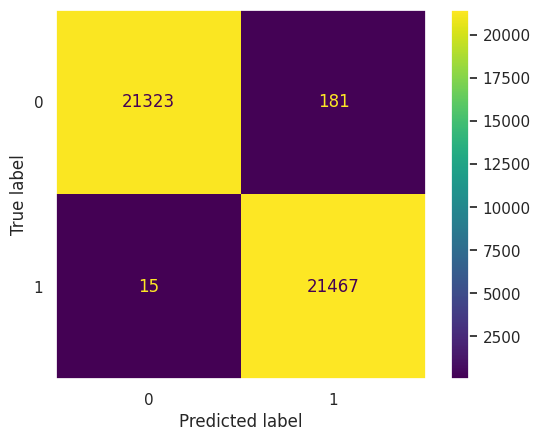

In [ ]:
fig, ax = plt.subplots()
# Hide grid lines
ax.grid(False)

ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1),
                                        y_pred.argmax(axis=1),
                                        ax = ax )
plt.show()

# Prediction same model with all rules

In [ ]:
%env name=test_samples1_512_4VR_equiv

# copy samples file to directory
!cp ./drive/Shareddrives/Memoria/samples/$name.zip ./$name.zip

!unzip -o -q $name.zip -d ./samples_equiv

env: name=test_samples1_512_4VR_equiv


Evaluate on test data
8334/8334 [==============================] - 41s 5ms/step - loss: 11.5888 - categorical_accuracy: 0.7590
test loss, test acc: [11.588846206665039, 0.7589799761772156]
3125/3125 [==============================] - 11s 4ms/step
              precision    recall  f1-score   support

           0       0.69      0.96      0.80     50359
           1       0.93      0.56      0.70     49641

    accuracy                           0.76    100000
   macro avg       0.81      0.76      0.75    100000
weighted avg       0.81      0.76      0.75    100000



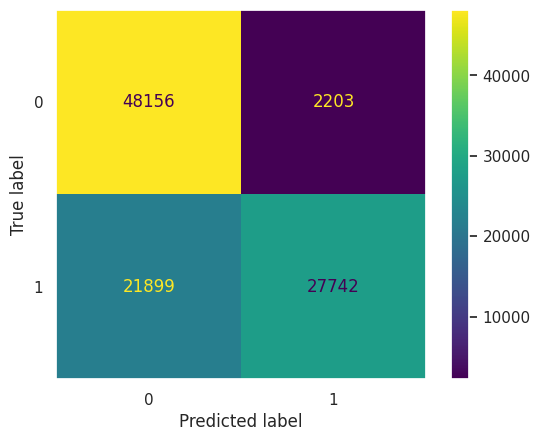

In [ ]:
inp_img_dir2 = "./samples_equiv/"

class1_equiv = [0, 255,
                8, 64, 239, 253,
                32, 251,
                40, 96, 235, 249,
                128, 254,
                136, 192, 238, 252,
                160, 250,
                168, 224, 234, 248]

class2_equiv = [1, 127,
                2, 16, 191, 247,
                3, 17, 63, 119,
                4, 223,
                5, 95,
                6, 20, 159, 215,
                7, 21, 31, 87,
                9, 65, 111, 125,
                10, 80, 175, 245,
                11, 47, 81, 117,
                12, 68, 207, 221,
                13, 69, 79, 93,
                14, 84, 143, 213,
                15, 85,
                19, 55,
                23,
                24, 66, 189, 231,
                25, 61, 67, 103,
                26, 82, 167, 181,
                27, 39, 53, 83,
                28, 70, 157, 199,
                29, 71,
                33, 123,
                34, 48, 187, 243,
                35, 49, 59, 115,
                36, 219,
                37, 91,
                38, 52, 155, 211,
                42, 112, 171, 241,
                43, 113,
                44, 100, 203, 217,
                46, 116, 139, 209,
                50, 179,
                51,
                56, 98, 185, 227,
                57, 99,
                58, 114, 163, 177,
                62, 118, 131, 145,
                72, 237,
                73, 109,
                74, 88, 173, 229,
                76, 205,
                77,
                78, 92, 141, 197,
                94, 133,
                104, 233,
                108, 201,
                130, 144, 190, 246,
                132, 222,
                134, 148, 158, 214,
                138, 174, 208, 224,
                140, 196, 206, 220,
                142, 212,
                152, 188, 194, 230,
                154, 166, 180, 210,
                156, 198,
                162, 176, 186, 242,
                164, 218,
                170, 240,
                172, 202, 216, 228,
                178,
                184, 226,
                200, 236,
                204,
                232]
class3_equiv = [18, 183,
                22, 151,
                30, 86, 135, 149,
                45, 75, 89, 101,
                60, 102, 153, 195,
                90, 165,
                105,
                122, 161,
                126, 129,
                146, 182,
                150]
class4_equiv = [41, 97, 107, 121,
                54, 147,
                106, 120, 169, 225,
                110, 124, 137, 193]

c1_img_list_equiv = getPics(class1_equiv
                            + class2_equiv
                            + class3_equiv, inp_img_dir2)
c4_img_list_equiv = getPics(class4_equiv, inp_img_dir2)


files_target_equiv = [
    np.full(len(c1_img_list_equiv), '1', dtype=str),
    np.full(len(c4_img_list_equiv), '4', dtype=str),
]

c1_x_equiv = c1_img_list_equiv.copy()
c4_x_equiv = c4_img_list_equiv.copy()

c1_y_equiv = files_target_equiv[0].copy()
c4_y_equiv = files_target_equiv[1].copy()

c_x_equiv = np.array(c1_x_equiv + c4_x_equiv)
c_y_equiv = np.concatenate((c1_y_equiv, c4_y_equiv))

dataset_equiv = pd.DataFrame({'img':c_x_equiv, 'class':c_y_equiv})
dataset_equiv = dataset_equiv.sample(frac=1)[:100000]

# get data from df
X_test_equiv = dataset_equiv['img'].values
y_test_equiv = dataset_equiv['class'].values.reshape(-1,1)

# one hot encoding
enc = joblib.load('./drive/Shareddrives/Memoria/encodings/encoder' + 'resnet_V2_4vr' + '.joblib')

# transform data
y_test_equiv = enc.transform(y_test_equiv)


# Load imgs
X_test_equiv = getImages(X_test_equiv)

# Model
model_equiv = keras.models.load_model('./drive/Shareddrives/Memoria/code/best_models/resnet_V2_4vr_best.h5')

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_equiv = model_equiv.evaluate(X_test_equiv, y_test_equiv, batch_size=12)
print("test loss, test acc:", results_equiv)

y_pred_equiv = model_equiv.predict(X_test_equiv)

print(classification_report(y_test_equiv.argmax(axis=1), y_pred_equiv.argmax(axis=1)))

fig, ax = plt.subplots()
# Hide grid lines
ax.grid(False)

ConfusionMatrixDisplay.from_predictions(y_test_equiv.argmax(axis=1),
                                        y_pred_equiv.argmax(axis=1),
                                        ax = ax
                                        )
plt.show()